## Identify the synthetic lethal interaction by outlier statistics *-- Random Shuffling*

After ROC analysis, robust Z-score can be used to identify SL interaction when we use consensus hit as validation data. 

Random shuffling would be further applied to identify the reasonable threshold for classifying true SL and non-SL in our dataset.

**Input**
- Integrated dataset (contain A1, A2 information, A2 CNV, A1 gene dependency scores): HUGE_dataset.csv
- Paralog gene list (~36.6k paralog pairs from Ensembl): DeKegel_TableS8.csv (https://doi.org/10.1101/2020.12.16.423022). In paralog gene list, Barbara had already annotated the minimum sequence identity and paralog gene family size.
- BROAD CRISPR gene dependency scores (Standard Z-score, Robust Z-score, Ranking)

**Output**


In [14]:
## Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
## Load dataset 
test_df = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/03_HUGE_dataset/HUGE_dataset.csv', index_col=False) 
test_df[:2]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol,BROAD_ID,A2_CNV,A1_Chronosscore,A1_StandardZscore,A1_RobustZscore,A1_Ranking
0,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,ACH-000948,Gain,0.052967,0.353450,0.492425,212.0
1,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,ACH-000011,Neutral,-0.374167,-1.681954,-3.452557,692.0


In [16]:
pairs_to_test = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/01_candidate_pairs_to_test/pairs_to_test.csv', index_col = None)
pairs_to_test[:2]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol
0,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2
1,ABR_BCR,BCR,ABR,613,29,ENSG00000186716,ENSG00000159842,ABR,613-29,BCR_ABR


In [17]:
## CRISPR gene effect 
crispr_broad = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/1_data_processing/04_paralog_genes/crispr_broad_paralog.csv', index_col=None)
stand_z_gene_effect = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/02_CRISPR_gene_dependency_scores_processing/crispr_broad_paralog_standardZscore.csv', index_col=None)
robust_z_gene_effect = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/02_CRISPR_gene_dependency_scores_processing/crispr_broad_paralog_robustZscore.csv', index_col=None)
rank_gene_effect = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/02_CRISPR_gene_dependency_scores_processing/crispr_broad_paralog_ranking.csv', index_col=None)

### Random shuffling (100 times)

Shuffle A1 gene in A1-A2 pairs and select the pairs with gene dependency scores (Chronos gene dependency scores, Standard Z-score, Robust Z-score, Ranking) lower than set threshold as pseudo-SL.

In [18]:
def check_n_SLs(threshold, A1_Zscore, test_df, ranking=False):

    pd.DataFrame(test_df).loc[:,'SL'] = test_df[A1_Zscore] <= threshold
    if ranking:
        pd.DataFrame(test_df).loc[:,'SL'] = test_df[A1_Zscore] >= threshold
    
    
    return sum(test_df.SL)
  

In [137]:
for i in range(100):
    
    # subset test_df
    test_df_subset = test_df[['A1_entrez', 'A1_RobustZscore', 'A1_StandardZscore', 'A1_Ranking', 'A1_Chronosscore']]
    # Shuffle A1, keep A2 remains unchanged 
    shuffle_init = pairs_to_test[['A1_entrez', 'A2_entrez']]

    # Shuffle A1
    pd.DataFrame(shuffle_init).loc[:,'A1_entrez'] = shuffle_init['A1_entrez'].sample(frac=1).reset_index(drop=True)
    # Add column pairs_to_test_symbol to the shuffled df
    pd.DataFrame(shuffle_init).loc[:, 'pairs_to_test'] = shuffle_init['A1_entrez'].astype(str).str.cat(shuffle_init['A2_entrez'].astype(str), sep='_')
    # pairs candidate 
    pairs_candidate_shuffle = shuffle_init.pairs_to_test.astype(str)  

    # Again, construct huge dataset for testing 
    # Generate basic information dataframe (paralog pairs info and BROAD ID)
    # 703: 703 cell lines for testing
    shuffle_repeated = pd.DataFrame(np.repeat(shuffle_init.values, 703, axis = 0), columns = shuffle_init.columns).reset_index(drop=True)


    # Combine BROAD ID, A2_CNV information (no shuffling, based on A2)
    shuffle_huge = pd.concat([shuffle_repeated, test_df[['BROAD_ID', 'A2_CNV']]], axis = 1)
    
    # Subset the data (only keep the sample with A2 CNV deletion)
    shuffle_huge = shuffle_huge[shuffle_huge['A2_CNV'] == 'Deletion']

    # Construct huge dataset for identification 
    for j in range(pairs_candidate_shuffle.shape[0]):

        df = shuffle_huge[shuffle_huge['pairs_to_test'] == pairs_candidate_shuffle[j]]

        # Get gene dependency score of A1
        # Get gene dependency score of A1
        df_crispr = crispr_broad[['BROAD_ID', str(df.A1_entrez.iloc[0])]]
        df_crispr_StandardZscore = stand_z_gene_effect[[str(df.A1_entrez.iloc[0])]]
        df_crispr_RobustZscore = robust_z_gene_effect[[str(df.A1_entrez.iloc[0])]]
        df_crispr_Ranking = rank_gene_effect[[str(df.A1_entrez.iloc[0])]]

        # Rename the column
        df_crispr = df_crispr.rename(columns = {str(df.A1_entrez.iloc[0]):'A1_Chronosscore'})
        df_crispr_StandardZscore = df_crispr_StandardZscore.rename(columns = {str(df.A1_entrez.iloc[0]):'A1_StandardZscore'})
        df_crispr_RobustZscore = df_crispr_RobustZscore.rename(columns = {str(df.A1_entrez.iloc[0]):'A1_RobustZscore'})
        df_crispr_Ranking = df_crispr_Ranking.rename(columns = {str(df.A1_entrez.iloc[0]):'A1_Ranking'})
        
    
        # Combine together for A1 score
        ls = [df_crispr, df_crispr_StandardZscore, df_crispr_RobustZscore, df_crispr_Ranking]
        df_A1_score = pd.concat(ls, axis=1)
        
        # Merge the dataframe (A2 status and A1 dependency score)
        df_map = pd.merge(df, df_A1_score, on = ['BROAD_ID'], how = 'left')


        if j == 0:
            shuffle_huge_score = df_map

        else:
            shuffle_huge_score = pd.concat([shuffle_huge_score, df_map])
    
    
    # Identify SL based on various threshold 
    # Set the threshold for SL identification
    threshold_Zscore = np.arange(-7, 0.1, 0.1)
    for h in range(len(threshold_Zscore)):
        # Identify the number of SLs
        n_SLs_standard = check_n_SLs(threshold_Zscore[h], 'A1_StandardZscore', shuffle_huge_score)
        n_SLs_robust = check_n_SLs(threshold_Zscore[h], 'A1_RobustZscore', shuffle_huge_score)
        
        
        if h == 0:
            shuffle_results_standard = pd.DataFrame(columns = ['n_SLs_shuffle_'+str(i+1)])
            shuffle_results_robust = pd.DataFrame(columns = ['n_SLs_shuffle_'+str(i+1)])
            
            # Fill in the results 
            shuffle_results_standard.loc[h] = n_SLs_standard
            shuffle_results_robust.loc[h] = n_SLs_robust
            
        
        else:
            shuffle_results_standard.loc[h] = n_SLs_standard
            shuffle_results_robust.loc[h] = n_SLs_robust
            
    
    
    threshold_Chronos = np.arange(-2, -0.45, 0.05)
    for c in range(len(threshold_Chronos)):
        # Identify the number of SLs
        n_SLs_Chronos = check_n_SLs(threshold_Chronos[c], 'A1_Chronosscore', shuffle_huge_score)
        
        if c == 0:
            shuffle_results_Chronos = pd.DataFrame(columns = ['n_SLs_shuffle_'+str(i+1)])
        
            # Fill in the results 
            shuffle_results_Chronos.loc[c] = n_SLs_Chronos
            
        
        else:
            shuffle_results_Chronos.loc[c] = n_SLs_Chronos
    
    
    
    
    
    threshold_ranking = np.arange(640, 704, 1)
    for r in range(len(threshold_ranking)):
        # Identify the number of SLs
        n_SLs_ranking = check_n_SLs(threshold_ranking[r], 'A1_Ranking', shuffle_huge_score, ranking=True)
        
        if r == 0:
            shuffle_results_ranking = pd.DataFrame(columns = ['n_SLs_shuffle_'+str(i+1)])
        
            # Fill in the results 
            shuffle_results_ranking.loc[r] = n_SLs_ranking
            
        
        else:
            shuffle_results_ranking.loc[r] = n_SLs_ranking
    
    
    if i == 0:
        threshold_col_robust = pd.DataFrame({'RobustZscore_threshold':threshold_Zscore})
        threshold_col_standard = pd.DataFrame({'StandardZscore_threshold':threshold_Zscore})
        threshold_col_Chronos = pd.DataFrame({'Chronosscore_threshold':threshold_Chronos})
        threshold_col_ranking = pd.DataFrame({'Ranking_threshold':threshold_ranking})
        
        
        shuffle_results_huge_standard = pd.concat([threshold_col_standard,shuffle_results_standard], axis = 1)
        shuffle_results_huge_robust = pd.concat([threshold_col_robust,shuffle_results_robust], axis = 1)
        shuffle_results_huge_ranking = pd.concat([threshold_col_ranking,shuffle_results_ranking], axis = 1)
        shuffle_results_huge_Chronos = pd.concat([threshold_col_Chronos, shuffle_results_Chronos], axis=1)
        
    else:
        shuffle_results_huge_standard = pd.concat([shuffle_results_huge_standard , shuffle_results_standard], axis = 1)
        shuffle_results_huge_robust = pd.concat([shuffle_results_huge_robust, shuffle_results_robust], axis = 1)
        shuffle_results_huge_ranking = pd.concat([shuffle_results_huge_ranking, shuffle_results_ranking], axis = 1)
        shuffle_results_huge_Chronos = pd.concat([shuffle_results_huge_Chronos, shuffle_results_Chronos], axis=1)
        

In [138]:
## Save the data 
shuffle_results_huge_standard.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_standard.csv', index=False)
shuffle_results_huge_robust.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_robust.csv', index=False)
shuffle_results_huge_ranking.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_ranking.csv', index=False)
shuffle_results_huge_Chronos.to_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_Chronos.csv', index=False)


In [19]:
## Load the shuffled results for plotting

shuffle_standard = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_standard.csv', index_col=None)
shuffle_robust = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_robust.csv', index_col=None)
shuffle_ranking = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_ranking.csv', index_col=None)
shuffle_Chronos = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/n_shuffle_Chronos.csv', index_col=None)


In [20]:
## test_df
huge_df = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/03_HUGE_dataset/HUGE_dataset.csv', index_col=False) 
test_df_del = huge_df[huge_df['A2_CNV']=='Deletion']
## Get the number of SLs based on various threshold 
# Zscore 
threshold_Zscore = np.arange(-7, 0.1, 0.1)
for h in range(len(threshold_Zscore)):
    
    # Identify the number of SLs
    n_SLs_standard = check_n_SLs(threshold_Zscore[h], 'A1_StandardZscore', test_df_del)
    n_SLs_robust = check_n_SLs(threshold_Zscore[h], 'A1_RobustZscore', test_df_del)
        
        
    if h == 0:
        origin_results_standard = pd.DataFrame(columns = ['StandardZscore_threshold','n_SLs_origin'])
        origin_results_robust = pd.DataFrame(columns = ['RobustZscore_threshold','n_SLs_origin'])
            
        # Fill in the results 
        origin_results_standard.loc[h] = [threshold_Zscore[h], n_SLs_standard]
        origin_results_robust.loc[h] = [threshold_Zscore[h], n_SLs_robust]
            
        
    else:
        origin_results_standard.loc[h] = [threshold_Zscore[h], n_SLs_standard]
        origin_results_robust.loc[h] = [threshold_Zscore[h], n_SLs_robust]
            
            
# Ranking 
threshold_ranking = np.arange(640, 704, 1)
for r in range(len(threshold_ranking)):
    # Identify the number of SLs
    n_SLs_ranking = check_n_SLs(threshold_ranking[r], 'A1_Ranking', test_df_del, ranking=True)
      
        
    if r == 0:
        origin_results_ranking = pd.DataFrame(columns = ['Ranking_threshold','n_SLs_origin'])
        
        # Fill in the results 
        origin_results_ranking.loc[r] = [threshold_ranking[r],n_SLs_ranking]
            
        
    else:
        origin_results_ranking.loc[r] = [threshold_ranking[r],n_SLs_ranking]

        
# Chronos
threshold_Chronos = np.arange(-2, -0.45, 0.05)
for c in range(len(threshold_Chronos)):
    # Identify the number of SLs
    n_SLs_Chronos = check_n_SLs(threshold_Chronos[c], 'A1_Chronosscore', test_df_del)
      
        
    if c == 0:
        origin_results_Chronos = pd.DataFrame(columns = ['Chronos_threshold','n_SLs_origin'])
        
        # Fill in the results 
        origin_results_Chronos.loc[c] = [threshold_Chronos[c],n_SLs_Chronos]
            
        
    else:
        origin_results_Chronos.loc[c] = [threshold_Chronos[c],n_SLs_Chronos]

        
        

## Merge the original data results and shuffled results 
n_SLs_standard_df = pd.concat([origin_results_standard, shuffle_standard.iloc[:,1:]], axis = 1)
n_SLs_robust_df = pd.concat([origin_results_robust, shuffle_robust.iloc[:,1:]], axis = 1)
n_SLs_ranking_df = pd.concat([origin_results_ranking, shuffle_ranking.iloc[:,1:]], axis = 1)
n_SLs_Chronos_df = pd.concat([origin_results_Chronos, shuffle_Chronos.iloc[:,1:]], axis = 1)



In [23]:
## Plot the original and shuffling curve
def draw_shuffling_curve(n_SLs_df, ax, robust = False, standard = False, ranking = False, Chronos = False):
    
    if robust:
        x = n_SLs_df['RobustZscore_threshold']
        color = '#E69F00'
    elif standard:
        x = n_SLs_df['StandardZscore_threshold']
        color = 'black'
    elif ranking:
        x = n_SLs_df['Ranking_threshold']
        color= 'steelblue'
    elif Chronos:
        x = n_SLs_df['Chronos_threshold']
        color = '#F44E3B'
    
    ## Plot 
    for i in range(1,101):
            if i == 1:
                y = n_SLs_df['n_SLs_origin']
                ax.plot(x, y, label = 'Observed', color = color, lw = 2)
            elif i == 2:
                y = n_SLs_df.iloc[:,i]
                ax.plot(x, y, label = 'Shuffled (x100)', color = '#999999', lw = 0.3)
            else:
                y = n_SLs_df.iloc[:,i]
                ax.plot(x, y, label = '', color = '#999999', lw = 0.3)
        

    if robust or standard or Chronos:
        ax.invert_xaxis()

     
    # Spine of the plot 
    ax.legend(frameon=False, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

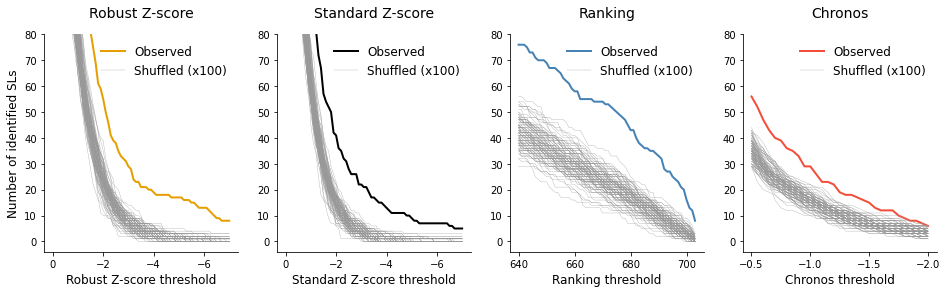

In [24]:
## Plot the original and shuffling curve 
## Plot 
f, axes = plt.subplots(1,4, figsize=(16,4), gridspec_kw={'width_ratios': [1,1,1,1]})
# plt.suptitle('All candidate paris to test', 
#              fontweight='bold', horizontalalignment='center', fontsize = 15, y=1.1)

ax1 = draw_shuffling_curve(n_SLs_robust_df, axes[0], robust=True)
# ax1.set_xlim(-2,-7)
ax1.set_ylim(-4,80)
ax1.set_title('Robust Z-score', fontsize=14, y = 1.05)
ax1.set_ylabel('Number of identified SLs',fontsize=12)
ax1.set_xlabel('Robust Z-score threshold', fontsize=12)


ax2 = draw_shuffling_curve(n_SLs_standard_df, axes[1], robust = False, standard=True, ranking=False)
# ax2.set_xlim(-2,-7)
ax2.set_title('Standard Z-score', fontsize=14, y = 1.05)
ax2.set_ylim(-4,80)
ax2.set_xlabel('Standard Z-score threshold', fontsize=12)


ax3 = draw_shuffling_curve(n_SLs_ranking_df, axes[2], ranking=True)
ax3.set_title('Ranking', fontsize=14, y = 1.05)
ax3.set_xlabel('Ranking threshold', fontsize=12)
ax3.set_ylim(-4,80)
# ax3.set_xlim(640, 703)

ax4 = draw_shuffling_curve(n_SLs_Chronos_df, axes[3], Chronos=True)
ax4.set_title('Chronos', fontsize=14, y = 1.05)
ax4.set_xlabel('Chronos threshold', fontsize=12)
# ax4.set_xlim(-0.5, -2)
ax4.set_ylim(-4,80)


f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/shuffling_curve.pdf', dpi=400, bbox_inches = 'tight')

### False Discovery Rate (FDR)

$$FDR = \frac{\text{mean of no. of SLs by shuffling 100 times at each threshold}}{\text{observed no. of SLs at each threshold}}$$

In [10]:
## All candidate pairs to test 
n_SLs_standard_df.loc[:,'mean_n_SLs_shuffle'] = n_SLs_standard_df.iloc[:,2:].mean(axis=1)
n_SLs_standard_df.loc[:,'fdr'] = n_SLs_standard_df['mean_n_SLs_shuffle']/n_SLs_standard_df['n_SLs_origin']

n_SLs_robust_df.loc[:,'mean_n_SLs_shuffle'] = n_SLs_robust_df.iloc[:,2:].mean(axis=1)
n_SLs_robust_df.loc[:,'fdr'] = n_SLs_robust_df['mean_n_SLs_shuffle']/n_SLs_robust_df['n_SLs_origin']

n_SLs_ranking_df.loc[:,'mean_n_SLs_shuffle'] = n_SLs_ranking_df.iloc[:,2:].mean(axis=1)
n_SLs_ranking_df.loc[:,'fdr'] = n_SLs_ranking_df['mean_n_SLs_shuffle']/n_SLs_ranking_df['n_SLs_origin']

n_SLs_Chronos_df.loc[:,'mean_n_SLs_shuffle'] = n_SLs_Chronos_df.iloc[:,2:].mean(axis=1)
n_SLs_Chronos_df.loc[:,'fdr'] = n_SLs_Chronos_df['mean_n_SLs_shuffle']/n_SLs_Chronos_df['n_SLs_origin']


In [11]:
## Plotting 
def draw_fdr(all_pairs_to_test_df, ax, robust = False, standard = False, Chronos=False):
    

    x1 = all_pairs_to_test_df.iloc[:,0]
    y1 = all_pairs_to_test_df['fdr']
    
    # x2 = closest_pairs_to_test_df.iloc[:,0]
    # y2 = closest_pairs_to_test_df['fdr']
    
    # ax.plot(x1, y1, label='All (n=341)', color = '#F44E3B')
    if robust:
        ax.plot(x1, y1, color = '#E69F00')
    elif standard:
        ax.plot(x1, y1, color = 'black')
    elif Chronos:
        ax.plot(x1, y1, color = '#F44E3B')
    else:
        ax.plot(x1, y1, color = 'steelblue')
    
    # ax.legend(frameon=False, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if robust or standard or Chronos:
        ax.invert_xaxis()
    
    return ax
    


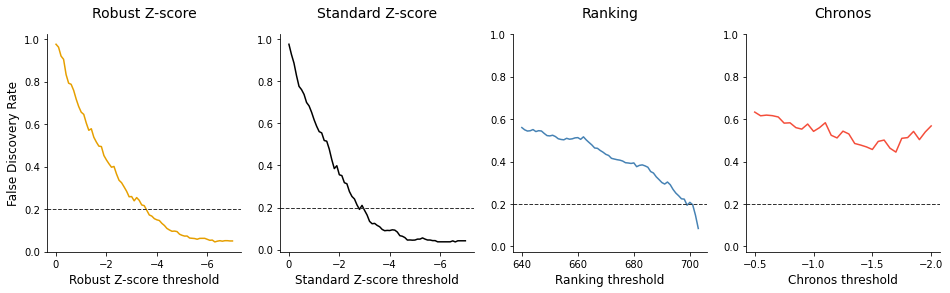

In [12]:
f, axes = plt.subplots(1,4, figsize=(16,4), gridspec_kw={'width_ratios': [1,1,1,1]})

ax1 = draw_fdr(n_SLs_standard_df, axes[1], standard=True)

ax1.set_xlabel('Standard Z-score threshold', fontsize=12)
ax1.set_title('Standard Z-score', fontsize=14, y = 1.05)
ax1.axhline(y=0.2, ls = '--', color = '#333333', linewidth = 1)

ax2 = draw_fdr(n_SLs_robust_df, axes[0], robust=True)
ax2.set_ylabel('False Discovery Rate', fontsize=12)
ax2.set_xlabel('Robust Z-score threshold', fontsize=12)
ax2.set_title('Robust Z-score', fontsize=14, y = 1.05)
ax2.axhline(y=0.2, ls = '--', color = '#333333', linewidth = 1)

ax3 = draw_fdr(n_SLs_ranking_df, axes[2])
ax3.set_xlabel('Ranking threshold', fontsize=12)
ax3.set_title('Ranking', fontsize=14, y = 1.05)
ax3.axhline(y=0.2, ls = '--', color = '#333333', linewidth = 1)
ax3.set_ylim(-0.025,1)


ax4 = draw_fdr(n_SLs_Chronos_df, axes[3], Chronos=True)
ax4.set_xlabel('Chronos threshold', fontsize=12)
ax4.set_title('Chronos', fontsize=14, y = 1.05)
ax4.axhline(y=0.2, ls = '--', color = '#333333', linewidth = 1)
ax4.set_ylim(-0.025, 1)



f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/05_identify_SL_interaction_random_shuffling/FDR_curve.pdf', dpi=400, bbox_inches = 'tight')

**Threshold chosen at which FDR < 0.2**

In [13]:
threshold_robustZ = max(n_SLs_robust_df[n_SLs_robust_df.fdr <= 0.2].RobustZscore_threshold)
print('Robust Z-score threshold when FDR <= 0.2:', np.round(threshold_robustZ, decimals = 3))

threshold_standardZ = max(n_SLs_standard_df[n_SLs_standard_df.fdr <= 0.2].StandardZscore_threshold)
print('Standard Z-score threshold when FDR <= 0.2:', np.round(threshold_standardZ, decimals = 3))

threshold_ranking = max(n_SLs_ranking_df[n_SLs_ranking_df.fdr <= 0.2].Ranking_threshold)
print('Ranking threshold when FDR <= 0.2:', np.round(threshold_ranking, decimals = 3))


Robust Z-score threshold when FDR <= 0.2: -3.6
Standard Z-score threshold when FDR <= 0.2: -2.8
Ranking threshold when FDR <= 0.2: 703
